<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/2019%20Deep%20Learning%5C2019_Deep_Learning_3_Image_XY_coordinates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regression with BIWI head pose dataset [1:34:03](https://youtu.be/PW2HKkzdkKY?t=5643)

[lesson3-head-pose.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-head-pose.ipynb)

Two more before we kind of rewind. The first one I'm going to show you is an interesting data set called the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db). Gabriele Fanelli was kind enough to give us permission to use this in the class. His team created this cool dataset.

![alt text](https://github.com/hiromis/notes/raw/master/lesson3/b1.png?raw=true)

Here's what the data set looks like. It's actually got a few things in it. We're just going to do a simplified version, and one of the things they do is they have a dot saying this is the center of the face. **So we're going to try and create a model that can find this dot on the face**.



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

**Getting and converting the data**

For this dataset, there's a few dataset specific things we have to do which I don't really even understand but I just know from the readme that you have to. They use some kind of depth sensing camera, I think they actually use Xbox Kinect.

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/biwi_head_pose/24'),
 PosixPath('/root/.fastai/data/biwi_head_pose/09'),
 PosixPath('/root/.fastai/data/biwi_head_pose/22.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/02'),
 PosixPath('/root/.fastai/data/biwi_head_pose/04'),
 PosixPath('/root/.fastai/data/biwi_head_pose/23'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/07'),
 PosixPath('/root/.fastai/data/biwi_head_pose/11.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/13'),
 PosixPath('/root/.fastai/data/biwi_head_pose/20.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/05'),
 PosixPath('/root/.fastai/data/biwi_head_pose/17.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/io_sample.cpp'),
 PosixPath('/root/.fastai/data/biwi_head_pose/14'),
 PosixPath('/root/.fastai/data/biwi_head_pose/08.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/17'),
 PosixPath('/root/.fastai/data/biwi_head_pose/10.obj'),
 PosixPath('/root/.fastai

There's some kind of calibration numbers that they provide in a little file which I had to read in:

In [0]:
cal = np.genfromtxt(path/'01'/'rgb.cal',skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

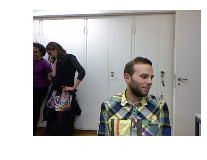

In [0]:
img = open_image(path/fname)
img.show()

In [0]:
ctr = np.genfromtxt(img2txt_name(fname),skip_header=3);ctr

array([187.332 ,  40.3892, 893.135 ])

Then they provided a little function that you have to use to take their coordinates to change it from this depth sensor calibration thing to end up with actual coordinates.

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2]+cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2]+cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f),skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size,pts),scale=True)

So when you open this and you see these conversion routines, I'm just doing what they told us to do basically. It's got nothing particularly to do with deep learning to end up with this red dot.

In [0]:
get_ctr(fname)

tensor([263.9104, 428.5814])

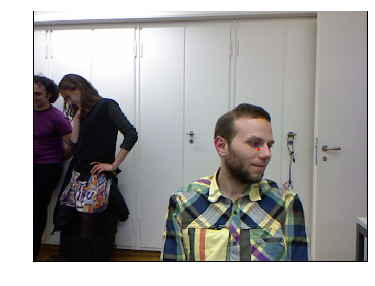

In [0]:
ctr =get_ctr(fname)
img.show(y=get_ip(img,ctr),figsize=(6,6))

**The interesting bit really is where we create something which is not an image or an image segment but an image points. We'll mainly learn about this later in the course, but basically image points use this idea of coordinates. They're not pixel values, they're XY coordinates (just two numbers).**

Here's an example for a particular image file name (09/frame_00667_rgb.jpg). The coordinates of the centre of the face are [263.9104, 428.5814]. So there's just two numbers which represent whereabouts on this picture is the center of the face. **So if we're going to create a model that can find the center of a face, we need a neural network that spits out two numbers. But note, this is not a classification model. These are not two numbers that you look up in a list to find out that they're road or building or ragdoll cat or whatever. They're actual locations**.

**So far, everything we've done has been a classification model﹣something that created labels or classes. This, for the first time, is what we call a regression model. A lot of people think regression means linear regression, it doesn't. Regression just means any kind of model where your output is some continuous number or set of numbers. So we need to create an image regression model (i.e. something that can predict these two numbers). How do you do that? Same way as always.**

**Creating a dataset**

In [0]:
data = (PointsItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name=='13')
       .label_from_func(get_ctr)
       .transform(get_transforms(),tfm_y=True,size=(120,160))
       .databunch().normalize(imagenet_stats)
       )

We can actually just say:

- I've got a list of image files.
- It's in a folder.
- I'm going to split it according to some function. So in this case, the files they gave us are from videos. So I picked just one folder (13) to be my validation set (i.e. a different person). So again, I was trying to think about how do I validate this fairly, so I said the the fair validation would be to make sure that it works well on a person that it's never seen before. So my validation set is all going to be a particular person.
- I want to label them using this function that we wrote that basically does the stuff that the readme says to grab the coordinates out of their text files. So that's going to give me the two numbers for every one.
- Create a dataset. This data set, I just tell it what kind of data set it is ﹣ they're going to be a set of points of specific coordinates.
- Do some transforms. Again, I have to say tfm_y=True because that red dot needs to move if I flip or rotate or warp.
- Pick some size. I just picked a size that's going to work pretty quickly.
- Create a data bunch.
- Normalize it.

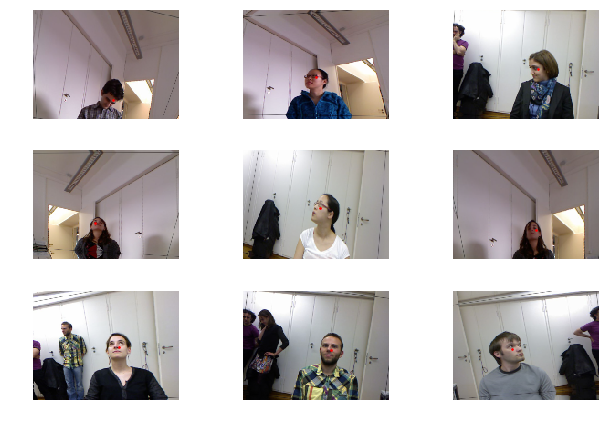

In [0]:
data.show_batch(3,figsize=(9,6))

I noticed that their red dots don't always seem to be quite in the middle of the face. I don't know exactly what their internal algorithm for putting dots on. It sometimes looks like it's meant to be the nose, but sometimes it's not quite the nose. Anyway it's somewhere around the center of the face or the nose.


## **Create a regression model** [1:38:59](https://youtu.be/PW2HKkzdkKY?t=5939)

So how do we create a model? We create a CNN. We're going to be learning a lot about loss functions in the next few lessons, but basically the loss function is that number that says how good is the model. **For classification, we use this loss function called cross-entropy loss which says basically "Did you predict the correct class and were you confident of that prediction?" We can't use that for regression, so instead we use something called mean squared error**. If you remember from last lesson, we actually implemented mean squared error from scratch. It's just the difference between the two, squared, and added up together.



In [0]:
learn = cnn_learner(data,models.resnet34)
#learn.loss_func = MSELossFlat()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 105913554.24it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


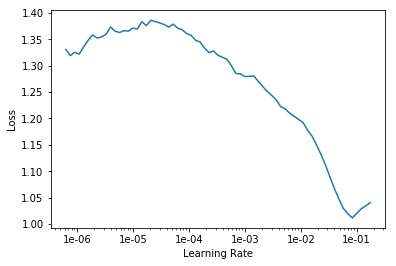

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [0]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,time
0,0.048620,0.006302,03:35
1,0.017669,0.002846,03:34
2,0.008462,0.007236,03:37
3,0.005193,0.001433,03:37
4,0.004016,0.001761,03:38


Once we've created the learner, we've told it what loss function to use, we can go ahead and do lr_find, then fit and you can see here within a minute and a half our mean squared error is 0.0004.

The nice thing is about mean squared error, that's very easy to interpret. We're trying to predict something which is somewhere around a few hundred, and we're getting a squared error on average of 0.0004. So we can feel pretty confident that this is a really good model. Then we can look at the results:

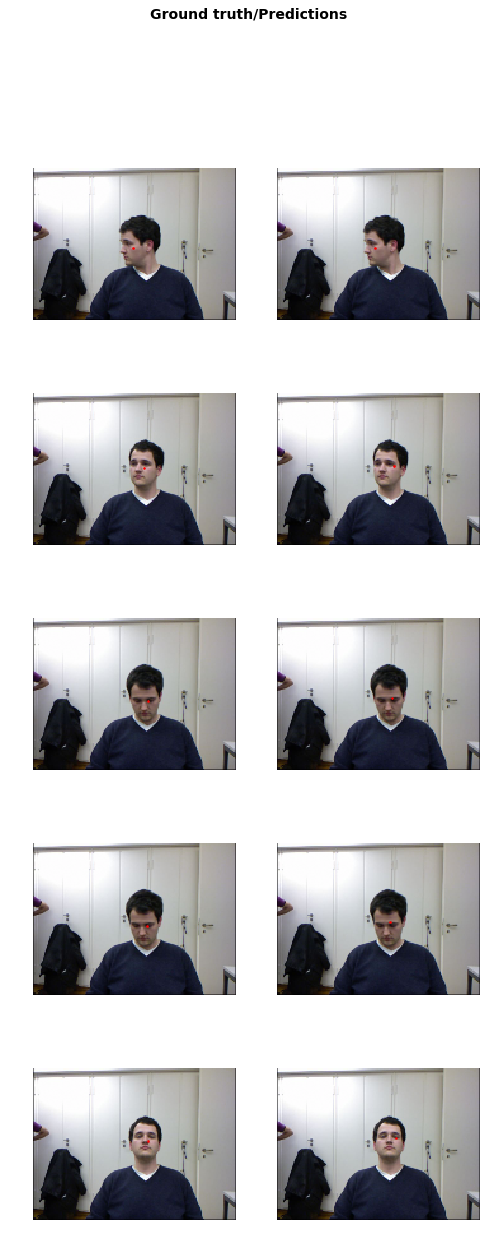

In [0]:
learn.show_results()

It's doing nearly perfect job. That's how you can do image regression models. Anytime you've got something you're trying to predict which is some continuous value, you use an approach that's something like this.

#First introduction to NLP - IMDB [1:41:07](https://youtu.be/PW2HKkzdkKY?t=6067)

[lesson3-imdb.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb)

Last example before we look at more foundational theory stuff, NLP. Next week, we're going to be looking at a lot more NLP, but let's now do the same thing but rather than creating a classification of pictures, let's try and classify documents. We're going to go through this in a lot more detail next week, but let's do the quick version.

In [0]:
from fastai.text import *

Rather than importing from fastai.vision, I now import, for the first time, from fastai.text. That's where you'll find all the application specific stuff for analyzing text documents.

In this case, we're going to use a dataset called IMDB. IMDB has lots of movie reviews. They're generally about a couple of thousand words, and each movie review has been classified as either negative or positive.

In [30]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

It's just in a CSV file, so we can use pandas to read it and we can take a little look.

In [33]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [34]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

Basically as per usual, we can either use factory methods or the data block API to create a data bunch. So here's the quick way to create a data bunch from a CSV of texts.

In [0]:
data_lm = TextDataBunch.from_csv(path,'texts.csv')

At this point I could create a learner and start training it, but we're going to show you a little bit more detail which we mainly going to look at next week. The steps that actually happen when you create these data bunches, there's a few steps:

1. **Tokenization**: it takes those words and converts them into a standard form of tokens. Basically each token represents a word.

![alt text](https://github.com/hiromis/notes/blob/master/lesson3/35.png?raw=true)

    But it does things like, see how "didn't" has been turned here into two separate words (did and n't)? And everything has been lowercased. See how "you're" has been turned into two separate words (you and 're)? So tokenization is trying to make sure that each "token" (i.e. each thing that we've got with spaces around it) represents a single linguistic concept. Also it finds words that are really rare (e.g. really rare names) and replaces them with a special token called unknown (xxunk). **Anything's starting with xx in fastai is some special token. This is tokenization, so we end up with something where we've got a list of tokenized words. You'll also see that things like punctuation end up with spaces around them to make sure that they're separate tokens.**

2. **Numericalization**: The next thing we do is we take a complete unique list of all of the possible tokens﹣ that's called the vocab which gets created for us.



```
data.vocab.itos[:10]
-------------

['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']
```

    So here is every possible token (the first ten of them) that appear in all of the movie reviews. We then replace every movie review with a list of numbers.

```
data.train_ds[0][0].data[:10]

---------------
array([ 43,  44,  40,  34, 171,  62,   6, 352,   3,  47])
```

    The list of numbers simply says what numbered thing in the vocab is in this place.

So through tokenization and numericalization, this is the standard way in NLP of turning a document into a list of numbers.

We can do that with the data block API:


```
data = (TextList.from_csv(path,'texts.csv',cols='text')
.split_from_df(col=2)
.label_from_df(cols=0)
.databunch())
```

This time, it's not ImageFilesList, it's TextList from a CSV and create a data bunch. At that point, we can start to create a model.

**As we learn about it next week, when we do NLP classification, we actually create two models**:

1. The first model is something called a **language model** which we train in a kind of a usual way.

`learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)`

2. After we've created a language model, we **fine-tune it to create the classifier**. We create the data bunch of the classifier, create a learner, train it and we end up with some accuracy.

That's the really quick version. We're going to go through it in more detail next week, but you can see the basic idea of training an NLP classifier is very similar to creating every other model we've seen so far. The current state of the art for IMDB classification is actually the algorithm that we built and published with colleague named Sebastian Ruder and what I just showed you is pretty much the state of the art algorithm with some minor tweaks. You can get this up to about 95% if you try really hard. So this is very close to the state of the art accuracy that we developed.

**Question**: For a dataset very different than ImageNet like the satellite images or genomic images shown in lesson 2, we should use our own stats.

**Jeremy once said:**


```
If you’re using a pretrained model you need to use the same stats it was trained with.

```


Why it is that? Isn’t it that, normalized dataset with its own stats will have roughly the same distribution like ImageNet? The only thing I can think of, which may differ is skewness. Is it the possibility of skewness or something else the reason of your statement? And does that mean you don’t recommend using pre-trained model with very different dataset like the one-point mutation that you showed us in lesson 2? [1:46:53](https://youtu.be/PW2HKkzdkKY?t=6413)

- Nope. As you can see, I've used pre-trained models for all of those things. Every time I've used an ImageNet pre-trained model, I've used ImageNet stats. Why is that? Because that model was trained with those stats. For example, imagine you're trying to classify different types of green frogs. If you were to use your own per-channel means from your dataset, you would end up converting them to a mean of zero, a standard deviation of one for each of your red, green, and blue channels. Which means they don't look like green frogs anymore. They now look like grey frogs. But ImageNet expects frogs to be green. So you need to normalize with the same stats that the ImageNet training people normalized with. Otherwise the unique characteristics of your dataset won't appear anymore﹣you've actually normalized them out in terms of the per-channel statistics. So you should always use the same stats that the model was trained with.



#Matrix multiplication used alot in NNs

In every case, what we're doing here is we're using gradient descent with mini batches (i.e. stochastic gradient descent) to fit some parameters of a model. And those parameters are parameters to matrix multiplications. The second half of this part, we're actually going to learn about a little tweak called convolutions, but it's basically a type of matrix multiplication.

The thing is though, no amount of matrix multiplications is possibly going to create something that can read IMDB movie reviews and decide if it's positive or negative or look at satellite imagery and decide whether it's got a road in it﹣that's far more than a linear classifier can do. Now we know these are deep neural networks. Deep neural networks contain lots of these matrix multiplications, but every matrix multiplication is just a linear model. A linear function on top of a linear function is just another linear function. If you remember back to your high school math, you might remember that if you have a y = ax + b and then you stick another cy + d on top of that, it's still just another slope and another intercept. So no amount of stacking matrix multiplications is going to help in the slightest.

So what are these models actually? What are we actually doing? And here's the interesting thing﹣all we're actually doing is we literally do have a matrix multiplication (or a slight variation like a convolution that we'll learn about) but after each one, we do something called a non-linearity or an activation function. An activation function is something that takes the result of that matrix multiplication and sticks it through some function. These are some of the functions that we use (by [Sagar Sharma](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)):

![alt text](https://github.com/hiromis/notes/raw/master/lesson3/sagar.png?raw=true)

In the old days, the most common function that we used to use was **sigmoid**. And they have particular mathematical definitions. Nowadays, we almost never use those for these between each matrix multiply. Nowadays, we nearly always use this one﹣it's called a **rectified linear unit (ReLU)**. It's very important, when you're doing deep learning, to use big long words that sound impressive. Otherwise normal people might think they can do it too laughing. But just between you and me, a rectified linear unit is defined using the following function:

`max(x, 0)`

That's it. And if you want to be really exclusive, of course, you then shorten the long version and you call it a ReLU to show that you're really in the exclusive team. So this is a ReLU activation.

Here's the crazy thing. If you take your red green blue pixel inputs, and you chuck them through a matrix modification, and then you replace the negatives with zero, and you put it through another matrix modification, replace the negatives at zero, and you keep doing that again and again, you have a deep learning neural network. That's it.

#Universal approximation theorem [1:52:27](https://youtu.be/PW2HKkzdkKY?t=6747)

So how the heck does that work? An extremely cool guy called Michael Nielsen showed how this works. He has a very nice website (actually a book) [http://neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com) and he has these beautiful little JavaScript things where you can get to play around. Because this was back in the old days, this was back when we used to use sigmoids. What he shows is that if you have enough little matrix multiplications followed by sigmoids (exactly the same thing works for a matrix multiplication followed by a ReLU), you can actually create arbitrary shapes. **So this idea that these combinations of linear functions and nonlinearities can create arbitrary shapes actually has a name and this name is the universal approximation theorem**.

What it says is that if you have stacks of linear functions and nonlinearities, the thing you end up with can approximate any function arbitrarily closely. So you just need to make sure that you have a big enough matrix to multiply by, or enough of them. If you have this function which is just a sequence of matrix multiplies and nonlinearities where the nonlinearities can be basically any of these activation functions, if that can approximate anything, then all you need is some way to find the particular values of the weight matrices in your matrix multiplies that solve the problem you want to solve. We already know how to find the values of parameters. We can use gradient descent. So that's actually it.

The reason it's hard to understand intuitively is because we're talking about weight matrices that have (once you add them all up) something like a hundred million parameters. They're very big weight matrices. So your intuition about what multiplying something by a linear model and replacing the negative zeros a bunch of times can do, your intuition doesn't hold. You just have to accept empirically the truth is doing that works really well.

In part two of the course, we're actually going to build these from scratch. But just to skip ahead, you basically will find that it's going to be five lines of code. It's going to be a little for loop that goes t = x @ w1 , t2 = max(t, 0) , stick that in a for loop that goes through each weight matrix, and at the end calculate the loss function. Of course, we're not going to calculate the gradients ourselves because PyTorch does that for us. And that's about it.

**Question**: There's a question about tokenization. I'm curious about how tokenizing words works when they depend on each other such as San Francisco. [1:56:45](https://youtu.be/PW2HKkzdkKY?t=7005)

- How do you tokenize something like San Francisco. San Francisco contains two tokens San Francisco. That's it. That's how you tokenize San Francisco. The question may be coming from people who have done traditional NLP which often need to use these things called n-grams. N-rams are this idea of a lot of NLP in the old days was all built on top of linear models where you basically counted how many times particular strings of text appeared like the phrase San Francisco. That would be a bi-gram for an n-gram with an n of 2. **The cool thing is that with deep learning, we don't have to worry about that. Like with many things, a lot of the complex feature engineering disappears when you do deep learning. So with deep learning, each token is literally just a word (or in the case that the word really consists of two words like you're you split it into two words) and then what we're going to do is we're going to then let the deep learning model figure out how best to combine words together**. Now when we see like let the deep learning model figure it out, of course all we really mean is find the weight matrices using gradient descent that gives the right answer. There's not really much more to it than that.

Again, there's some minor tweaks. In the second half of the course, we're going to be learning about the particular tweak for image models which is using a convolution that'll be a CNN, for language there's a particular tweak we do called using recurrent models or an RNN, but they're very minor tweaks on what we've just described. So basically it turns out with an RNN, that it can learn that San plus Francisco has a different meaning when those two things are together.

**Question**: Some satellite images have 4 channels. How can we deal with data that has 4 channels or 2 channels when using pre-trained models? [1:59:09](https://youtu.be/PW2HKkzdkKY?t=7149)

**`--Fastai image models currently only deal with 3 channels--`**

- I think that's something that we're going to try and incorporate into fast AI. So hopefully, by the time you watch this video, there'll be easier ways to do this. But the basic idea is a pre-trained ImageNet model expects a red green and blue pixels. So if you've only got two channels, there's a few things you can do but basically you'll want to create a third channel. You can create the third channel as either being all zeros, or it could be the average of the other two channels. So you can just use you know normal PyTorch arithmetic to create that third channel. You could either do that ahead of time in a little loop and save your three channel versions, or you could create a custom dataset class that does that on demand.

- For 4 channel, you probably don't want to get rid of the 4th channel. So instead, what you'd have to do is to actually modify the model itself. So to know how to do that, we'll only know how to do in a couple more lessons time. But basically the idea is that the initial weight matrix (weight matrix is really the wrong term, they're not weight matrices; their weight tensors so they can have more than just two dimensions), so that initial weight tensor in the neural net, one of its axes is going to have three slices in it. So you would just have to change that to add an extra slice, which I would generally just initialize to zero or to some random numbers. So that's the short version. But really to understand exactly what I meant by that, we're going to need a couple more lessons to get there.

# Wrapping up [2:01:19](https://youtu.be/PW2HKkzdkKY?t=7279)

What have we looked at today? We started out by saying it's really easy now to create web apps. We've got starter kits for you that show you how to create web apps, and people have created some really cool web apps using what we've learned so far which is single label classification.

But the cool thing is the exact same steps we use to do single label classification, you can also do to:

- Multi-label classification such as in the planet dataset.
- Image segmentation.
- Any kind of image regression.
- NLP classification.
- and a lot more.

In each case, all we're actually doing is:

- Gradient descent
- Non-linearity

Universal approximation theorem tells us it lets us arbitrarily accurately approximate any given function including functions such as:

- Converting a spoken waveform into the thing the person was saying.
- Converting a sentence in Japanese to a sentence in English.
- Converting a picture of a dog into the word dog.

These are all mathematical functions that we can learn using this approach.

So this week, see if you can come up with an interesting idea of a problem that you would like to solve which is either multi-label classification, image regression, image segmentation, or something like that and see if you can try to solve that problem. You will probably find the hardest part of solving that problem is creating the data bunch and so then you'll need to dig into the data block API to try to figure out how to create the data bunch from the data you have. With some practice, you will start to get pretty good at that. It's not a huge API. There's a small number of pieces. It's also very easy to add your own, but for now, ask on the forum if you try something and you get stuck.

Next week, we're going to come back and we're going to look at some more NLP. We're going to learn some more about some details about how we actually train with SGD quickly. We're going to learn about things like Adam and RMSProp and so forth. And hopefully, we're also going to show off lots of really cool web apps and models that you've all built during the week, so I'll see you then. Thanks!